In [45]:
# ============================================================
# 0) LIBRARIES & GLOBALS
# ============================================================
import os, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.base import clone, BaseEstimator, RegressorMixin

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries loaded")

# -------- Version-safe RMSE helper (works on older sklearn) --------
def _rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))


✓ Libraries loaded


In [46]:
# ============================================================
# 1) LOAD ENGINEERED DATA FROM GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR  = "/content/drive/MyDrive/AdvMLAT3/processed"
MODEL_DIR = "/content/drive/MyDrive/AdvMLAT3/models"
os.makedirs(MODEL_DIR, exist_ok=True)

DATA_PATH = f"{DATA_DIR}/solana_features_engineered.csv"
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp').reset_index(drop=True)

target_col = "target_high_tomorrow"
assert target_col in df.columns, f"Missing `{target_col}` in {DATA_PATH}"

print(f"Data loaded: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} → {df['timestamp'].max().date()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded: (631, 126)
Date range: 2024-02-04 → 2025-10-26


In [47]:
# ============================================================
# 2) SAFE FEATURE PICKER (PAST-BASED ONLY, ROBUST TO NAMES)
# ============================================================
cols = set(df.columns)
def present(*cands):
    for c in cands:
        if c in cols: return c
    return None
def present_many(candidates):
    return [c for c in candidates if c in cols]

lag_list = [1, 2, 3, 5, 7, 14, 30]
lag_feats = []
for L in lag_list:
    lag_feats += [
        present(f'open_prev_{L}',  f'open_lag_{L}'),
        present(f'high_prev_{L}',  f'high_lag_{L}'),
        present(f'low_prev_{L}',   f'low_lag_{L}'),
        present(f'close_prev_{L}', f'close_lag_{L}')
    ]
lag_feats = [c for c in lag_feats if c]

roll_feats = []
for W in [7, 14, 30, 60, 90]:
    roll_feats += present_many([
        f'sma_close_{W}', f'ema_close_{W}', f'sma_high_{W}', f'std_close_{W}',
        f'low_min_{W}', f'high_max_{W}'
    ])

vol_feats = present_many([
    'rolling_vol_7d','rolling_vol_14d','rolling_vol_30d',
    'volatility_7d','volatility_14d','volatility_30d',
    'atr_7','atr_14','atr_7d','atr_14d',
    'parkinson_vol_30d','parkinson_volatility'
])

tech_feats = [
    present('rsi_14','rsi14'), present('rsi_7','rsi7'),
    present('macd','macd_line'), 'macd_signal', present('macd_hist','macd_histogram'),
    'bb_bandwidth','bb_percent'
]
tech_feats = [c for c in tech_feats if c]

price_feats = present_many([
    'pct_close_change','pct_high_change','pct_low_change',
    'pct_return_3d','pct_return_7d','pct_return_14d','pct_return_30d',
    'abs_price_shift','abs_price_shift_7d',
    'intraday_range','intraday_range_ratio',
    'open_gap','open_gap_pct',
    'momentum_7d','momentum_14d','momentum_7','momentum_14',
    'roc_7d','roc_14d','roc_7','roc_14'
])

time_feats = [
    present('day_of_week','dow'), present('week_of_year','woy'),
    present('day_of_month','dom'), 'month','quarter','year',
    present('day_of_week_sin','dow_sin'), present('day_of_week_cos','dow_cos'),
    'month_sin','month_cos',
    present('days_since_start','days_elapsed')
]
time_feats = [c for c in time_feats if c]

adv_feats = present_many([
    'close_position_30d', 'delta_sma30', 'delta_ema30',
    'wick_upper','wick_lower','body_length',
    'vol_sma_7','vol_ratio_7'
])

safe_features = [*lag_feats, *roll_feats, *vol_feats, *tech_feats, *price_feats, *time_feats, *adv_feats]
safe_features = [c for c in safe_features if c in df.columns]

# Drop near-constant columns (can block tree gain on small data)
nunq = df[safe_features].nunique(dropna=False)
constant_cols = nunq[nunq <= 1].index.tolist()
if constant_cols:
    safe_features = [c for c in safe_features if c not in constant_cols]
    print(f"🔎 Dropped near-constant features: {len(constant_cols)}")

print("\n🔒 SAFE FEATURES")
print(f"Found: {len(safe_features)}")
print("Sample:", safe_features[:15], ("... +" if len(safe_features)>15 else ""))



🔒 SAFE FEATURES
Found: 107
Sample: ['open_prev_1', 'high_prev_1', 'low_prev_1', 'close_prev_1', 'open_prev_2', 'high_prev_2', 'low_prev_2', 'close_prev_2', 'open_prev_3', 'high_prev_3', 'low_prev_3', 'close_prev_3', 'open_prev_5', 'high_prev_5', 'low_prev_5'] ... +


In [48]:
# ============================================================
# 3) PREPARE MATRICES & CLEAN MISSING
# ============================================================
timestamps = df['timestamp'].copy()
X_full = df[safe_features].copy()
y_full = df[target_col].astype(float).copy()

print(f"\nMissing values before: {X_full.isna().sum().sum()}")
X_full = X_full.fillna(method='ffill').fillna(method='bfill').fillna(0.0)
print(f"Missing values after:  {X_full.isna().sum().sum()}")
print(f"Final matrix: X={X_full.shape}, y={y_full.shape}")


Missing values before: 0
Missing values after:  0
Final matrix: X=(631, 107), y=(631,)


In [49]:
# ============================================================
# 4) BASELINES (NAIVE & ROLLING MEAN OF HIGH)
# ============================================================
def baseline_naive(y):
    y = y.reset_index(drop=True)
    pred = y.shift(1)
    mask = ~pred.isna()
    return mean_absolute_error(y[mask], pred[mask]), _rmse(y[mask], pred[mask])

def baseline_roll7(y):
    y = y.reset_index(drop=True)
    pred = y.rolling(7).mean().shift(1)
    mask = ~pred.isna()
    return mean_absolute_error(y[mask], pred[mask]), _rmse(y[mask], pred[mask])

naive_mae, naive_rmse = baseline_naive(y_full)
roll7_mae, roll7_rmse = baseline_roll7(y_full)
print(f"\nBaseline – Yesterday HIGH → MAE={naive_mae:.4f}, RMSE={naive_rmse:.4f}")
print(f"Baseline – 7d mean HIGH → MAE={roll7_mae:.4f}, RMSE={roll7_rmse:.4f}")


Baseline – Yesterday HIGH → MAE=4.7556, RMSE=6.7389
Baseline – 7d mean HIGH → MAE=9.5596, RMSE=12.7172


In [50]:
# ============================================================
# 5) TIME-SERIES CV HARNESS (KBest *inside* pipeline → no leakage)
#    Early stopping for LGBM/XGB by unwrapping the pipeline per fold.
# ============================================================
def make_pipe(estimator, scale=True, k=30):
    steps = []
    if scale:
        steps.append(('scaler', RobustScaler()))
    steps.append(('kbest', SelectKBest(score_func=f_regression, k=min(k, X_full.shape[1]))))
    steps.append(('model', estimator))
    return Pipeline(steps)

def _fit_with_es_if_supported(model, X_tr_t, y_tr, X_va_t, y_va):
    """Fit with early stopping if LGBM/XGB; else plain fit."""
    m = clone(model)
    if isinstance(m, LGBMRegressor):
        m.set_params(n_estimators=2000)
        try:
            m.fit(X_tr_t, y_tr, eval_set=[(X_va_t, y_va)],
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        except TypeError:
            m.fit(X_tr_t, y_tr)
        return m
    if isinstance(m, XGBRegressor):
        m.set_params(n_estimators=2000)
        try:
            m.fit(X_tr_t, y_tr, eval_set=[(X_va_t, y_va)],
                  early_stopping_rounds=50, verbose=False)
        except TypeError:
            m.fit(X_tr_t, y_tr)
        return m
    m.fit(X_tr_t, y_tr)
    return m

def ts_cv_scores(pipe, X, y, n_splits=3, label="model"):
    """
    Expanding-window CV with TimeSeriesSplit. If final estimator is LGBM/XGB,
    we apply preprocessing, then fit with early stopping on (X_va, y_va).
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses, r2s, maps = [], [], [], []
    oof = np.full(len(y), np.nan)

    for fold, (tr, va) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        if isinstance(pipe, Pipeline):
            final_est = pipe.steps[-1][1]
            preproc = Pipeline(pipe.steps[:-1]) if len(pipe.steps) > 1 else None

            if isinstance(final_est, (LGBMRegressor, XGBRegressor)):
                preproc_ = clone(preproc) if preproc is not None else None
                if preproc_ is not None:
                    preproc_.fit(X_tr, y_tr)
                    Xt_tr = preproc_.transform(X_tr)
                    Xt_va = preproc_.transform(X_va)
                else:
                    Xt_tr, Xt_va = X_tr, X_va
                fitted_model = _fit_with_es_if_supported(final_est, Xt_tr, y_tr, Xt_va, y_va)
                pred = fitted_model.predict(Xt_va)
            else:
                model_pipe = clone(pipe)
                model_pipe.fit(X_tr, y_tr)
                pred = model_pipe.predict(X_va)
        else:
            model_ = clone(pipe)
            model_.fit(X_tr, y_tr)
            pred = model_.predict(X_va)

        oof[va] = pred
        mae  = mean_absolute_error(y_va, pred)
        rmse = _rmse(y_va, pred)
        r2   = r2_score(y_va, pred)
        mape = mean_absolute_percentage_error(y_va, pred) * 100

        maes.append(mae); rmses.append(rmse); r2s.append(r2); maps.append(mape)
        print(f"[{label}] Fold {fold}: MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}  MAPE={mape:.2f}%")

    return {
        "label": label,
        "MAE_mean": float(np.mean(maes)), "MAE_std": float(np.std(maes)),
        "RMSE_mean": float(np.mean(rmses)), "RMSE_std": float(np.std(rmses)),
        "R2_mean": float(np.mean(r2s)), "R2_std": float(np.std(r2s)),
        "MAPE_mean": float(np.mean(maps)), "MAPE_std": float(np.std(maps)),
        "oof": oof
    }

In [51]:
# ============================================================
# 6) TIME-SERIES SAFE STACKER (avoids cross_val_predict)
# ============================================================
class TSStackingRegressor(BaseEstimator, RegressorMixin):
    """
    Time-series safe stacking:
    - Builds OOF predictions for base estimators using TimeSeriesSplit
    - Trains final_estimator on OOF rows only (no future leakage)
    - Refits base estimators on full data for inference
    """
    def __init__(self, estimators, final_estimator=None, n_splits=3, passthrough=False, random_state=None):
        self.estimators = estimators
        self.final_estimator = final_estimator if final_estimator is not None else Ridge(alpha=1.0)
        self.n_splits = n_splits
        self.passthrough = passthrough
        self.random_state = random_state

    def fit(self, X, y):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        y_sr = y if isinstance(y, pd.Series) else pd.Series(y)
        tscv = TimeSeriesSplit(n_splits=self.n_splits)

        n = len(y_sr)
        Z = np.zeros((n, len(self.estimators)), dtype=float)
        used = np.zeros(n, dtype=bool)

        # OOF predictions
        for j, est in enumerate(self.estimators):
            for tr, va in tscv.split(X_df):
                est_j = clone(est)
                est_j.fit(X_df.iloc[tr], y_sr.iloc[tr])
                Z[va, j] = est_j.predict(X_df.iloc[va])
                used[va] = True

        # Train meta on rows with OOF preds
        Z_meta = Z[used]
        y_meta = y_sr.iloc[used].values
        if self.passthrough:
            X_pass = X_df.iloc[used].values
            Z_meta = np.hstack([Z_meta, X_pass])

        self.final_estimator_ = clone(self.final_estimator).fit(Z_meta, y_meta)

        # Fit base on full data for prediction
        self.base_estimators_ = []
        for est in self.estimators:
            est_full = clone(est).fit(X_df, y_sr)
            self.base_estimators_.append(est_full)

        return self

    def predict(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        base_preds = [est.predict(X_df) for est in self.base_estimators_]
        Z = np.column_stack(base_preds)
        if self.passthrough:
            Z = np.hstack([Z, X_df.values])
        return self.final_estimator_.predict(Z)


In [52]:
# ============================================================
# 7) CANDIDATES (small-data friendly) + STACKING (TS-safe)
# ============================================================
candidates = {}

# LightGBM – Huber (small-data tuned)
candidates["lgb_small_huber"] = make_pipe(
    LGBMRegressor(
        objective="huber",
        n_estimators=400, learning_rate=0.05,
        num_leaves=8, max_depth=4,
        min_child_samples=5, min_gain_to_split=0.0,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=0.0,
        verbosity=-1, random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# LightGBM – Quantile median (α=0.5)
candidates["lgb_small_q50"] = make_pipe(
    LGBMRegressor(
        objective="quantile", alpha=0.5,
        n_estimators=600, learning_rate=0.05,
        num_leaves=16, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# LightGBM – Quantile upper (α=0.9)
candidates["lgb_small_q90"] = make_pipe(
    LGBMRegressor(
        objective="quantile", alpha=0.9,
        n_estimators=600, learning_rate=0.05,
        num_leaves=16, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# XGBoost – DART (small-ish)
candidates["xgb_dart_small"] = make_pipe(
    XGBRegressor(
        booster='dart', tree_method='hist',
        n_estimators=800, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0,
        enable_categorical=False, random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# Sklearn GradientBoosting – Huber
candidates["gbr_huber_small"] = make_pipe(
    GradientBoostingRegressor(
        loss='huber', alpha=0.9,
        n_estimators=600, learning_rate=0.05, max_depth=3,
        random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# Sklearn GradientBoosting – Quantile (upper)
candidates["gbr_q90_small"] = make_pipe(
    GradientBoostingRegressor(
        loss='quantile', alpha=0.9,
        n_estimators=800, learning_rate=0.05, max_depth=3,
        random_state=RANDOM_STATE
    ),
    scale=True, k=30
)

# ExtraTrees
candidates["extra_trees"] = make_pipe(
    ExtraTreesRegressor(
        n_estimators=800, max_features='sqrt', min_samples_leaf=2,
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    scale=True, k=30
)

# ElasticNet (your strong linear baseline)
candidates["elasticnet"] = make_pipe(
    ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=RANDOM_STATE),
    scale=True, k=30
)

# Stacking (TS-safe): LGB + XGB + ElasticNet -> Ridge
stack_estimators = [
    LGBMRegressor(
        n_estimators=600, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    ),
    XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist',
        random_state=RANDOM_STATE
    ),
    Pipeline([('std', StandardScaler()),
              ('en',  ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=RANDOM_STATE))])
]
ts_stacker = TSStackingRegressor(
    estimators=stack_estimators,
    final_estimator=Ridge(alpha=1.0),
    n_splits=3, passthrough=False, random_state=RANDOM_STATE
)
candidates["stacking"] = Pipeline([
    ('kbest', SelectKBest(score_func=f_regression, k=min(30, X_full.shape[1]))),
    ('model', ts_stacker)
])


Running expanding-window CV with n_splits=3

----------------------------------------------------------------------
Training lgb_small_huber
----------------------------------------------------------------------
[lgb_small_huber] Fold 1: MAE=16.7161  RMSE=25.7852  R²=0.5407  MAPE=8.02%
[lgb_small_huber] Fold 2: MAE=11.2556  RMSE=15.9869  R²=0.8417  MAPE=6.20%
[lgb_small_huber] Fold 3: MAE=7.4927  RMSE=9.8453  R²=0.8853  MAPE=3.87%

----------------------------------------------------------------------
Training lgb_small_q50
----------------------------------------------------------------------
[lgb_small_q50] Fold 1: MAE=16.2224  RMSE=24.8925  R²=0.5719  MAPE=7.81%
[lgb_small_q50] Fold 2: MAE=10.1101  RMSE=14.1469  R²=0.8760  MAPE=5.63%
[lgb_small_q50] Fold 3: MAE=7.4238  RMSE=9.7273  R²=0.8880  MAPE=3.86%

----------------------------------------------------------------------
Training lgb_small_q90
----------------------------------------------------------------------
[lgb_small_q90]

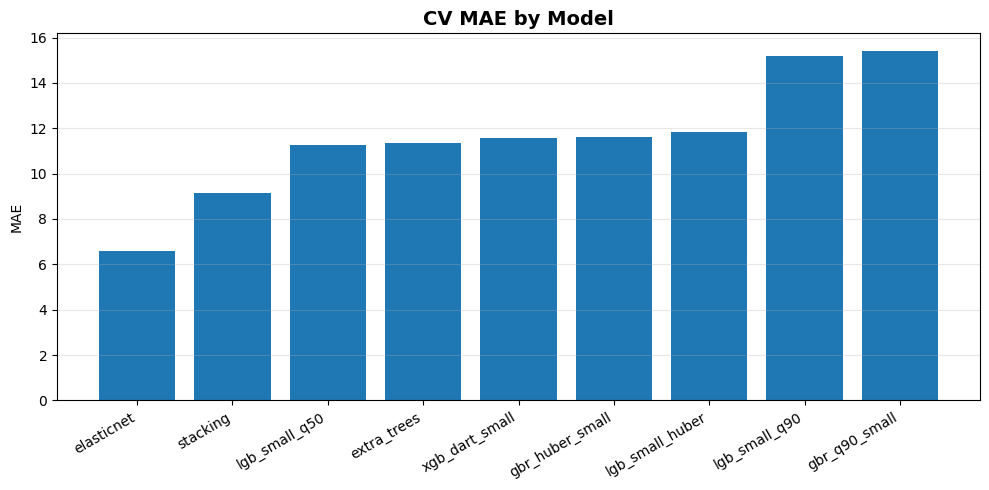

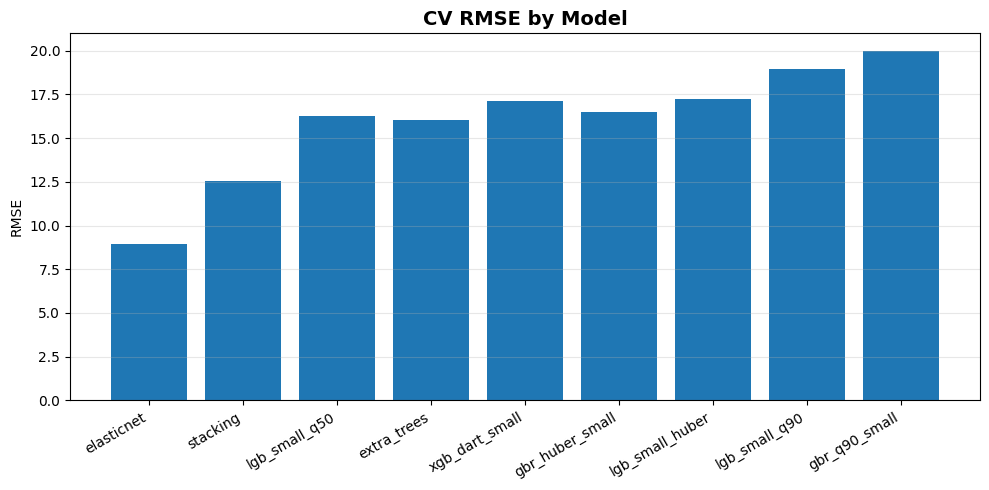


🏆 Best by MAE: elasticnet


In [53]:
# ============================================================
# 8) RUN CV FOR ALL MODELS (n_splits=3, larger folds)
# ============================================================
results = []
print("\n" + "="*70)
print("Running expanding-window CV with n_splits=3")
print("="*70)

for name, pipe in candidates.items():
    print("\n" + "-"*70)
    print(f"Training {name}")
    print("-"*70)
    res = ts_cv_scores(pipe, X_full, y_full, n_splits=3, label=name)
    results.append(res)

summary = pd.DataFrame([{
    "model": r["label"],
    "MAE_mean": r["MAE_mean"], "MAE_std": r["MAE_std"],
    "RMSE_mean": r["RMSE_mean"], "RMSE_std": r["RMSE_std"],
    "R2_mean": r["R2_mean"], "MAPE_mean": r["MAPE_mean"]
} for r in results]).sort_values("MAE_mean").reset_index(drop=True)

print("\nCV Summary (sorted by MAE):")
print(summary)

# Plot MAE / RMSE
plt.figure(figsize=(10,5))
plt.bar(summary["model"], summary["MAE_mean"])
plt.title("CV MAE by Model", fontsize=14, fontweight='bold'); plt.ylabel("MAE")
plt.xticks(rotation=30, ha='right'); plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.bar(summary["model"], summary["RMSE_mean"])
plt.title("CV RMSE by Model", fontsize=14, fontweight='bold'); plt.ylabel("RMSE")
plt.xticks(rotation=30, ha='right'); plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

best_name = summary.iloc[0]["model"]
print(f"\n🏆 Best by MAE: {best_name}")

In [54]:
# ============================================================
# 9) REFIT BEST PIPELINE ON ALL DATA & SAVE ARTIFACTS
# ============================================================
best_pipe = candidates[best_name]
best_pipe.fit(X_full, y_full)

artifact_pipe  = f"{MODEL_DIR}/solana_best_pipeline_{best_name}.joblib"
artifact_meta  = f"{MODEL_DIR}/solana_cv_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
artifact_feats = f"{MODEL_DIR}/solana_feature_columns.json"

joblib.dump(best_pipe, artifact_pipe)
with open(artifact_feats, "w") as f:
    json.dump(safe_features, f, indent=2)

meta = {
    "token": "SOL",
    "best_model": best_name,
    "summary_sorted_by_mae": summary.to_dict(orient="records"),
    "baselines": {
        "naive": {"MAE": float(naive_mae), "RMSE": float(naive_rmse)},
        "roll7": {"MAE": float(roll7_mae), "RMSE": float(roll7_rmse)}
    },
    "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "kbest_k": int(min(30, X_full.shape[1])),
    "random_state": RANDOM_STATE
}
with open(artifact_meta, "w") as f:
    json.dump(meta, f, indent=2)

print("\n" + "="*70)
print("✓ ARTIFACTS SAVED")
print("="*70)
print("Pipeline:", artifact_pipe)
print("Features:", artifact_feats)
print("Summary: ", artifact_meta)

# One-step-ahead prediction from the latest row
latest_pred = float(best_pipe.predict(X_full.iloc[[-1]])[0])
print(f"\nLatest t+1 HIGH prediction (using last row features): {latest_pred:.4f}")


✓ ARTIFACTS SAVED
Pipeline: /content/drive/MyDrive/AdvMLAT3/models/solana_best_pipeline_elasticnet.joblib
Features: /content/drive/MyDrive/AdvMLAT3/models/solana_feature_columns.json
Summary:  /content/drive/MyDrive/AdvMLAT3/models/solana_cv_summary_20251028_121303.json

Latest t+1 HIGH prediction (using last row features): 198.6639
